#School of Computing and Information Systems

#The University of Melbourne

##COMP90049, Introduction to Machine Learning, Semester 2 2025

Diabetes Health Indicators Dataset
[Source](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset)


<br><br>
Assignment 2: Group project
<br><br>
Group Name: Phoenix
Group ID: G06

Group Members:

*   Xinyang Sun – 1783329 – xinyang.sun.3@student.unimelb.edu.au
*   Nina Lock – 1786109 – ninalock@student.unimelb.edu.au
*   Vadym Musiienko – 1785479 – vmusiienko@student.unimelb.edu.au

In [ ]:
# Necessary imports
from google.colab import files
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Feature selection
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Model selection
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    make_scorer
)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Imbalanced-learn utilities
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
# Evaluation helper function

def evaluate_on_test(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"\n=== {name} (Test) ===")
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    print(f"Macro Precision: {prec:.4f}")
    print(f"Macro Recall:    {rec:.4f}")
    print(f"Macro F1:        {f1:.4f}")


    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize rows
    cm_percent = np.nan_to_num(cm_percent)  # handle division by zero safely
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                                  display_labels=["No diabetes (0)","Prediabetes (1)","Diabetes (2)"])
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"{name} — Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [ ]:
uploaded = files.upload()

In [ ]:
# Read csv file to dataframe
diabetes_data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
diabetes_data.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
# Copy diabetes dataset
diabetes_data_copy = diabetes_data.copy()

# Checking for missing values
print(diabetes_data_copy.isnull().sum(),"\n\n")

# Checking the datatype for every column
print(diabetes_data_copy.info())

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-nul

One observes, that there are no missing values and the features are all numerical features (type: float64). This is because people are doing a survey on the phone answering only in numerical/ ordinal numbers.  

In [ ]:
# Split dataset into features and target
# 'Diabetes_012' column contains target (decision if patient has no diabetes/ prediabetes or diabetes)
diabetes_features = diabetes_data.drop(columns=['Diabetes_012'])
diabetes_target = diabetes_data['Diabetes_012']

In [ ]:
# Calculating summary statistics of numerical features
# These statistics include the count, mean, std, min, max as well as the 25%, 50%, 75%
feature_statistics = diabetes_features.describe().T

# Since skewness only makes sense for non-binary features, I am excluding binary features
binary_features = [
    col for col in diabetes_features.columns
    if set(diabetes_features[col].dropna().unique()) <= {0, 1}
]
# Compute skewness only for non-binary features
non_binary_features = [col for col in diabetes_features.columns if col not in binary_features]
skewness_values = diabetes_features[non_binary_features].skew()

feature_statistics['skewness'] = skewness_values

# Print feature statistics
feature_statistics

,count,mean,std,min,25%,50%,75%,max,skewness
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0,NaN
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0,NaN
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0,NaN
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0,2.122004
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0,NaN
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0,NaN
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0,NaN
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0,NaN
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0,NaN
Veggies,253680.0,0.811420,0.391175,0.0,1.0,1.0,1.0,1.0,NaN


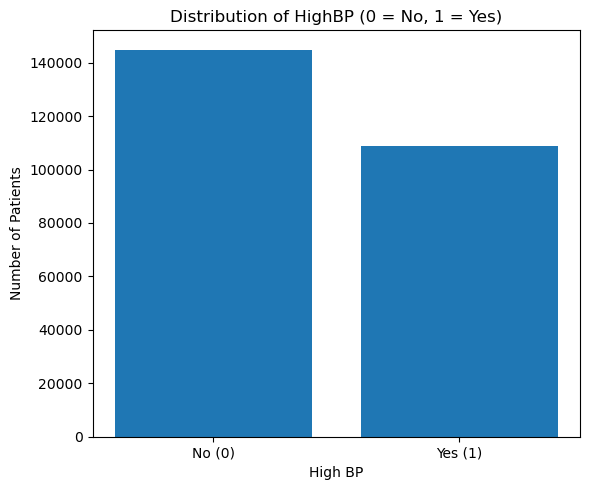

In [ ]:
# Performing explanatory data analysis (EDA) by plotting features in histograms and bar plots

# 1. HighBP (1) vs. No High BP (0)
highbp_counts = diabetes_data['HighBP'].value_counts().sort_index()

plt.figure(figsize=(6, 5))
plt.bar(highbp_counts.index.astype(str), highbp_counts.values)
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.xlabel("High BP")
plt.ylabel("Number of Patients")
plt.title("Distribution of HighBP (0 = No, 1 = Yes)")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of Patients with/without Cholesterol Check in 5 Years')

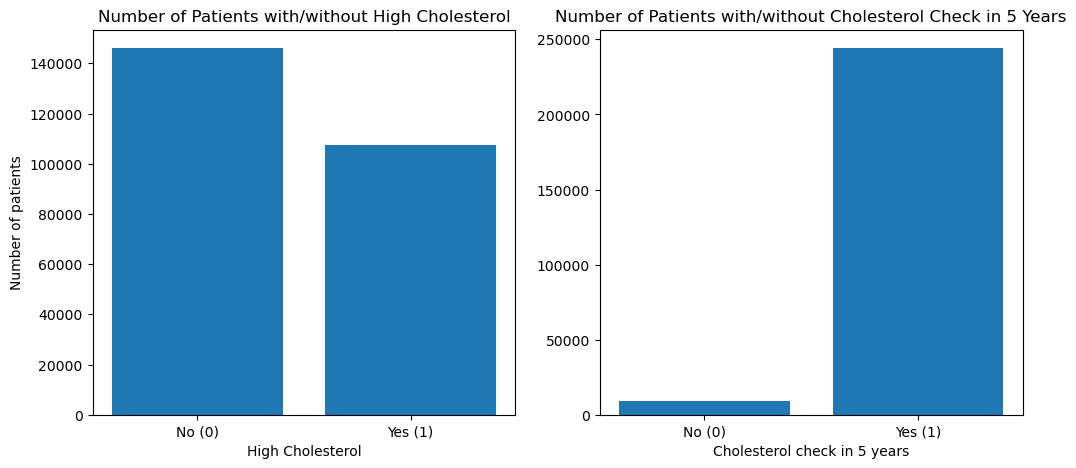

In [ ]:
# 2. Display cholesterol features (high/low cholesterol, cholerstol check in 5 years (yes/no))
high_cholesterol_counts = diabetes_data['HighChol'].value_counts().sort_index()
cholesterol_check_counts = diabetes_data['CholCheck'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting high cholesterol (yes/no)
axs[0].bar(high_cholesterol_counts.index.astype(str), high_cholesterol_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No (0)', 'Yes (1)'])
axs[0].set_xlabel("High Cholesterol")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Number of Patients with/without High Cholesterol")

# Plotting cholesterol check in 5 years (yes/no)
axs[1].bar(cholesterol_check_counts.index.astype(str), cholesterol_check_counts.values)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No (0)', 'Yes (1)'])
axs[1].set_xlabel("Cholesterol check in 5 years")
axs[1].set_title("Number of Patients with/without Cholesterol Check in 5 Years")

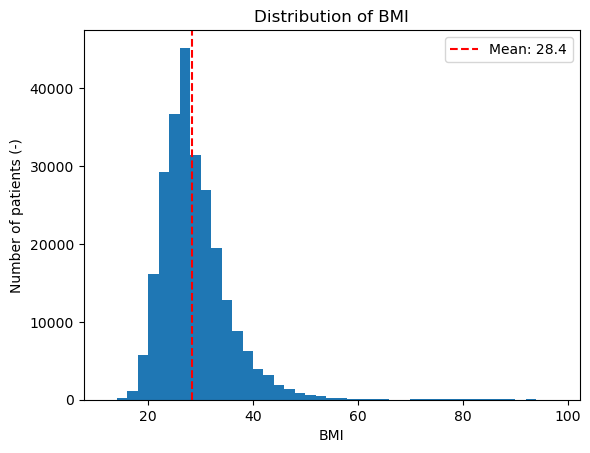

In [ ]:
# 3. BMI
bin_width_BMI = 2
bins_BMI = np.arange(feature_statistics['min']['BMI'],
                 feature_statistics['max']['BMI'] + bin_width_BMI,
                 bin_width_BMI)


# Plotting histogram
plt.hist(diabetes_data['BMI'], bins=bins_BMI);
plt.xlabel("BMI")
plt.ylabel("Number of patients (-)")
mean_BMI = diabetes_data['BMI'].mean()
plt.axvline(mean_BMI, color='r', linestyle='--', label=f'Mean: {mean_BMI:.1f}')
plt.title("Distribution of BMI")
plt.legend()


Text(0.5, 1.0, 'Distribution of Heavy Alcohol Drinkers')

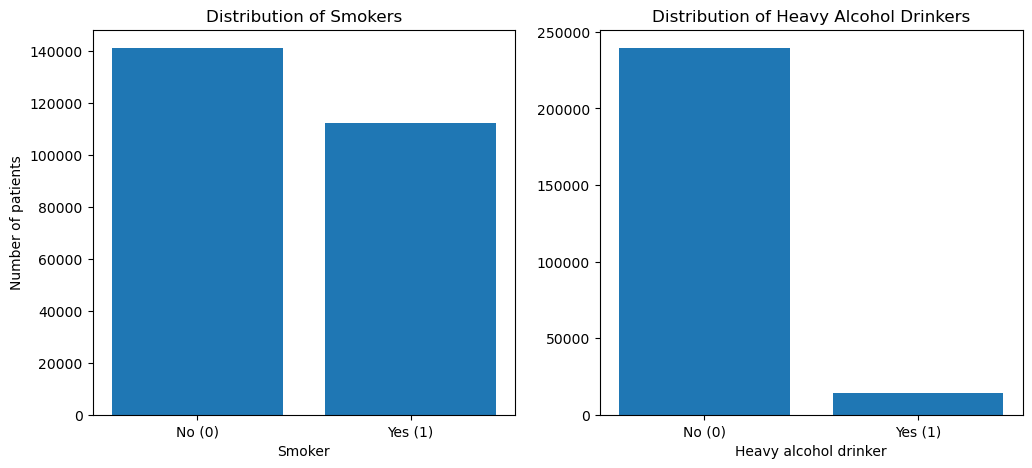

In [ ]:
# 4. Distribution of Smokers/ Non-Smokers and heavy alcohol drinkers
# Smokers: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes
smoker_counts = diabetes_data['Smoker'].value_counts().sort_index()

# Heavy alcohol drinkers: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes
heavy_alcohol_counts = diabetes_data['HvyAlcoholConsump'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting smoker distribution (yes/no)
axs[0].bar(smoker_counts.index.astype(str), smoker_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No (0)', 'Yes (1)'])
axs[0].set_xlabel("Smoker")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Distribution of Smokers")

# Plotting heavy drinker distribution (yes/no)
axs[1].bar(heavy_alcohol_counts.index.astype(str), heavy_alcohol_counts.values)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No (0)', 'Yes (1)'])
axs[1].set_xlabel("Heavy alcohol drinker")
axs[1].set_title("Distribution of Heavy Alcohol Drinkers")

Text(0.5, 1.0, 'Distribution of Patients with Heart Disease')

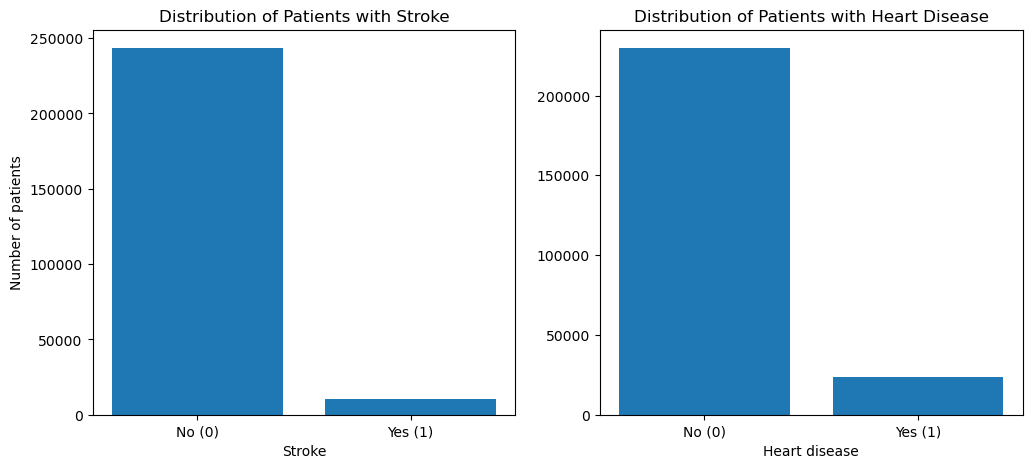

In [ ]:
# 5. Distribution of patients with clinical conditions (stroke, coronary heart disease (CHD) or myocardial infarction (MI))
stroke_counts = diabetes_data['Stroke'].value_counts().sort_index()
heart_disease_counts = diabetes_data['HeartDiseaseorAttack'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting distribution of patients with a previous stroke (yes/no)
axs[0].bar(stroke_counts.index.astype(str), stroke_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No (0)', 'Yes (1)'])
axs[0].set_xlabel("Stroke")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Distribution of Patients with Stroke")

# Plotting distribution of patients with a heart disease (yes/no)
axs[1].bar(heart_disease_counts.index.astype(str), heart_disease_counts.values)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No (0)', 'Yes (1)'])
axs[1].set_xlabel("Heart disease")
axs[1].set_title("Distribution of Patients with Heart Disease")

Text(0.5, 1.0, 'Distribution of Patients with Difficulty in Walking/ Climbing Stairs')

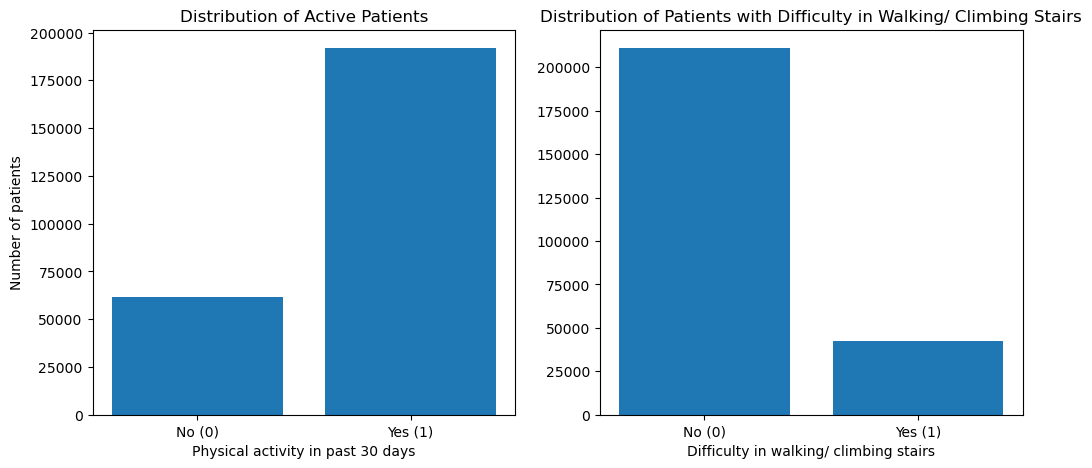

In [ ]:
# 5. Distribution of patients' physical activity
# physical activity in past 30 days - not including job 0 = no 1 = yes
# Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes

phy_activity_counts = diabetes_data['PhysActivity'].value_counts().sort_index()
diff_walk_disease_counts = diabetes_data['DiffWalk'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting distribution of active patients (yes/no)
axs[0].bar(phy_activity_counts.index.astype(str), phy_activity_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No (0)', 'Yes (1)'])
axs[0].set_xlabel("Physical activity in past 30 days")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Distribution of Active Patients")

# Plotting distribution of patients that have difficulty in walking/ climbing stairs (yes/no)
axs[1].bar(diff_walk_disease_counts.index.astype(str), diff_walk_disease_counts.values)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No (0)', 'Yes (1)'])
axs[1].set_xlabel("Difficulty in walking/ climbing stairs")
axs[1].set_title("Distribution of Patients with Difficulty in Walking/ Climbing Stairs")

Text(0.5, 1.0, 'Distribution of Patients Consuming Veggies')

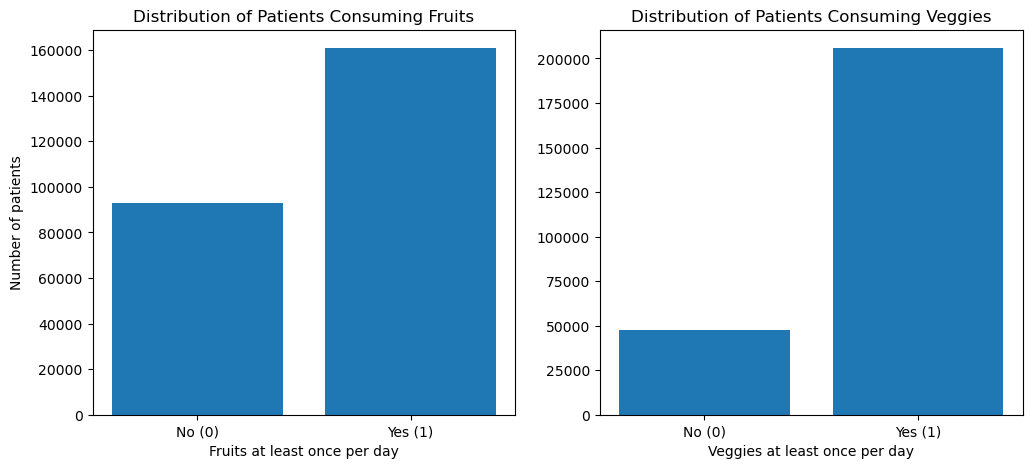

In [ ]:
# 6. Distribution of eating fruits and veggies

# Consume Fruit 1 or more times per day 0 = no 1 = yes
fruit_counts = diabetes_data['Fruits'].value_counts().sort_index()

# Consume Vegetables 1 or more times per day 0 = no 1 = yes
veggies_counts = diabetes_data['Veggies'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting distribution of patients eating fruits at least once per day
axs[0].bar(fruit_counts.index.astype(str), fruit_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No (0)', 'Yes (1)'])
axs[0].set_xlabel("Fruits at least once per day")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Distribution of Patients Consuming Fruits")

# Plotting distribution of patients eating veggies at least once per day
axs[1].bar(veggies_counts.index.astype(str), veggies_counts.values)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No (0)', 'Yes (1)'])
axs[1].set_xlabel("Veggies at least once per day")
axs[1].set_title("Distribution of Patients Consuming Veggies")

Text(0.5, 1.0, 'Distribution of Patients not going to Doctor because of Costs')

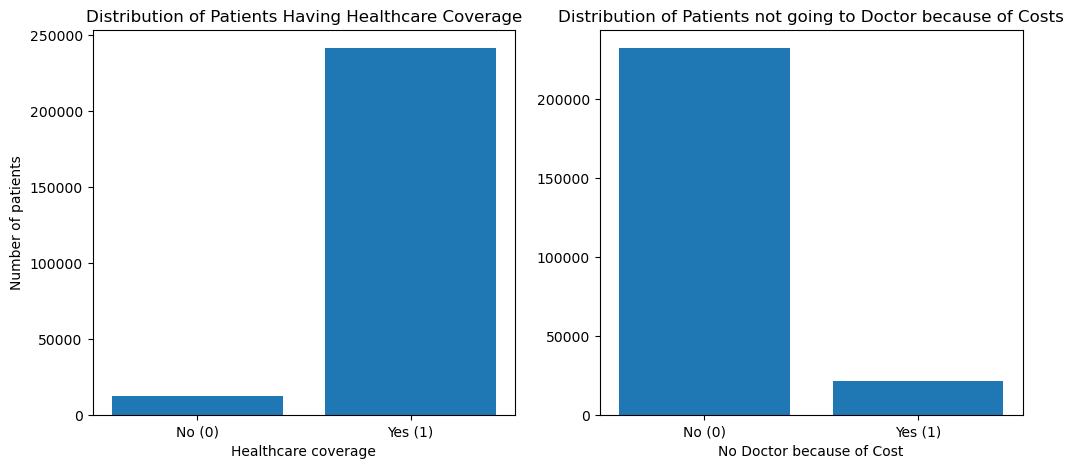

In [ ]:
# 7. Distribution of patients with healthcare, patients having problems paying for a doctor

# Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes
healthcare_counts = diabetes_data['AnyHealthcare'].value_counts().sort_index()

# Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes
noDocbcCost_counts = diabetes_data['NoDocbcCost'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting distribution of patients regarding their healthcare coverage
axs[0].bar(healthcare_counts.index.astype(str), healthcare_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['No (0)', 'Yes (1)'])
axs[0].set_xlabel("Healthcare coverage")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Distribution of Patients Having Healthcare Coverage")

# Plotting distribution of patients having problems paying for a doctor
axs[1].bar(noDocbcCost_counts.index.astype(str), noDocbcCost_counts.values)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No (0)', 'Yes (1)'])
axs[1].set_xlabel("No Doctor because of Cost")
axs[1].set_title("Distribution of Patients not going to Doctor because of Costs")

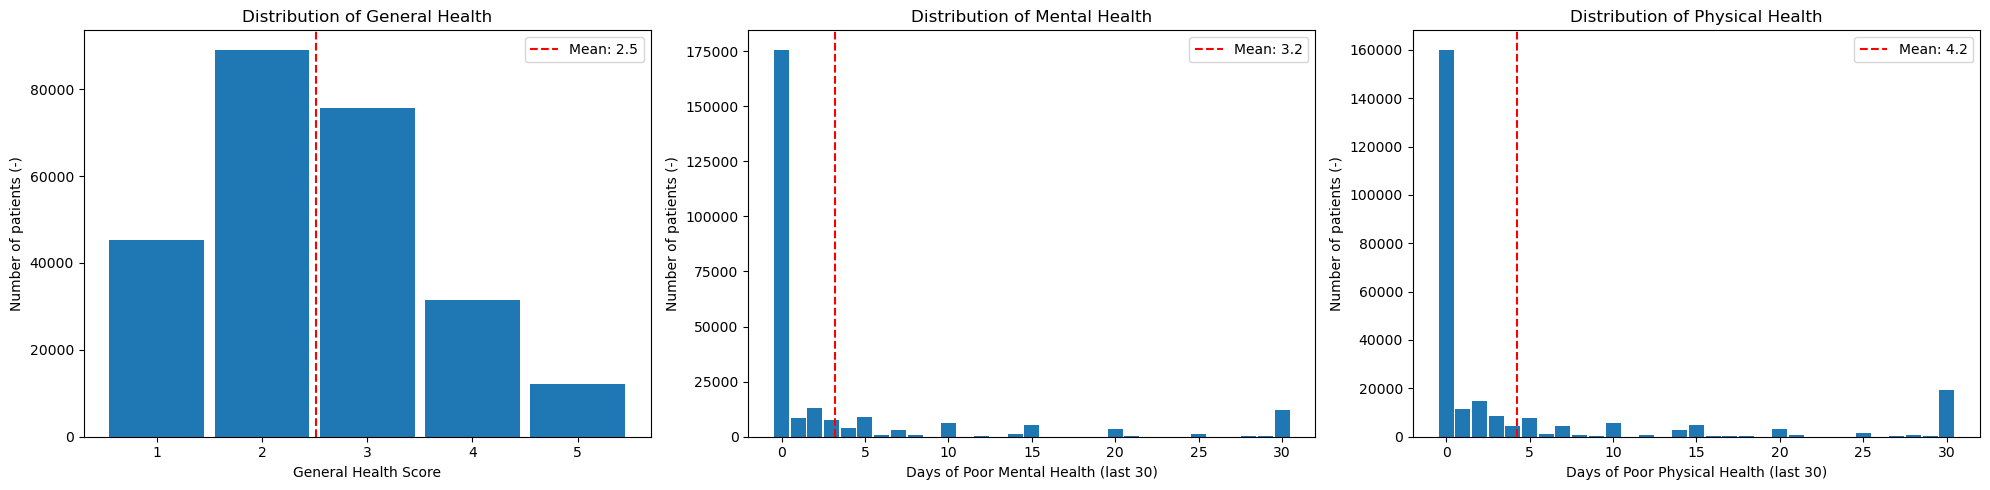

In [ ]:
# 8. Plotting distribution of general health, mental health, physical health
# General Health: Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor
# Mental Health: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days
# Physical Health: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days

bin_width_health = 1
bins_general_health = np.arange(1 - 0.5, 5 + 1.5, bin_width_health)
bins_30_days_health = np.arange(0 - 0.5, 30 + 1.5, bin_width_health)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# General Health
axs[0].hist(diabetes_data['GenHlth'], bins=bins_general_health, rwidth=0.9)
axs[0].set_xlabel("General Health Score")
axs[0].set_ylabel("Number of patients (-)")
mean_general_health = diabetes_data['GenHlth'].mean()
axs[0].axvline(mean_general_health, color='r', linestyle='--', label=f'Mean: {mean_general_health:.1f}')
axs[0].set_title("Distribution of General Health")
axs[0].legend()
axs[0].set_xticks([1, 2, 3, 4, 5])

# Mental Health
axs[1].hist(diabetes_data['MentHlth'], bins=bins_30_days_health, rwidth=0.9)
axs[1].set_xlabel("Days of Poor Mental Health (last 30)")
axs[1].set_ylabel("Number of patients (-)")
mean_mental_health = diabetes_data['MentHlth'].mean()
axs[1].axvline(mean_mental_health, color='r', linestyle='--', label=f'Mean: {mean_mental_health:.1f}')
axs[1].set_title("Distribution of Mental Health")
axs[1].legend()
axs[1].set_xticks(np.arange(0, 31, 5))

# Physical Health
axs[2].hist(diabetes_data['PhysHlth'], bins=bins_30_days_health, rwidth=0.9)
axs[2].set_xlabel("Days of Poor Physical Health (last 30)")
axs[2].set_ylabel("Number of patients (-)")
mean_physical_health = diabetes_data['PhysHlth'].mean()
axs[2].axvline(mean_physical_health, color='r', linestyle='--', label=f'Mean: {mean_physical_health:.1f}')
axs[2].set_title("Distribution of Physical Health")
axs[2].legend()
axs[2].set_xticks(np.arange(0, 31, 5))

plt.tight_layout()
plt.show()

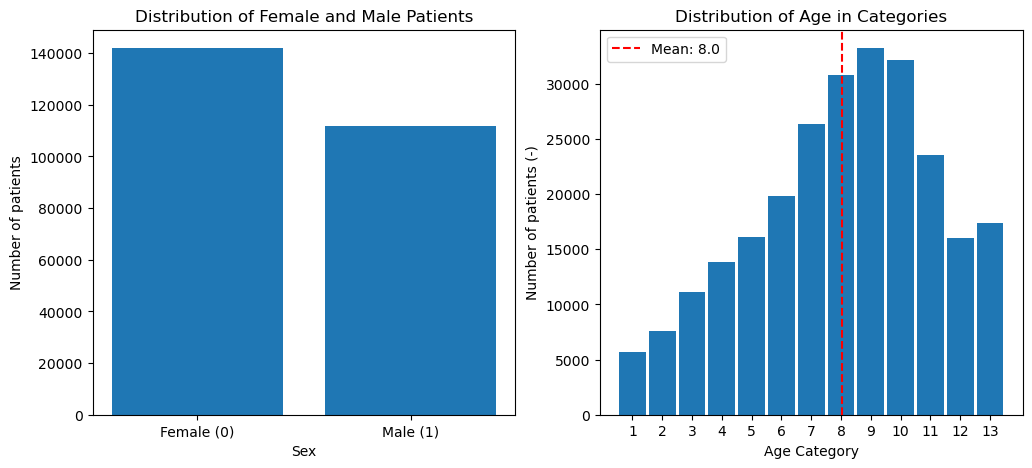

In [ ]:
# 9. Plotting demographic variables (sex, age)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting distribution of male/female patients
sex_counts = diabetes_data['Sex'].value_counts().sort_index()
axs[0].bar(sex_counts.index.astype(str), sex_counts.values)
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Female (0)', 'Male (1)'])
axs[0].set_xlabel("Sex")
axs[0].set_ylabel("Number of patients")
axs[0].set_title("Distribution of Female and Male Patients")

# Plotting distribution of ages
# 13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older
bin_width_age = 1
bins_age= np.arange(1 - 0.5, 13 + 1.5, bin_width_age)
axs[1].hist(diabetes_data['Age'], bins=bins_age, rwidth=0.9)
axs[1].set_xlabel("Age Category")
axs[1].set_ylabel("Number of patients (-)")
mean_age = diabetes_data['Age'].mean()
axs[1].axvline(mean_age, color='r', linestyle='--', label=f'Mean: {mean_age:.1f}')
axs[1].set_title("Distribution of Age in Categories")
axs[1].legend()
axs[1].set_xticks(np.arange(1, 14, 1));


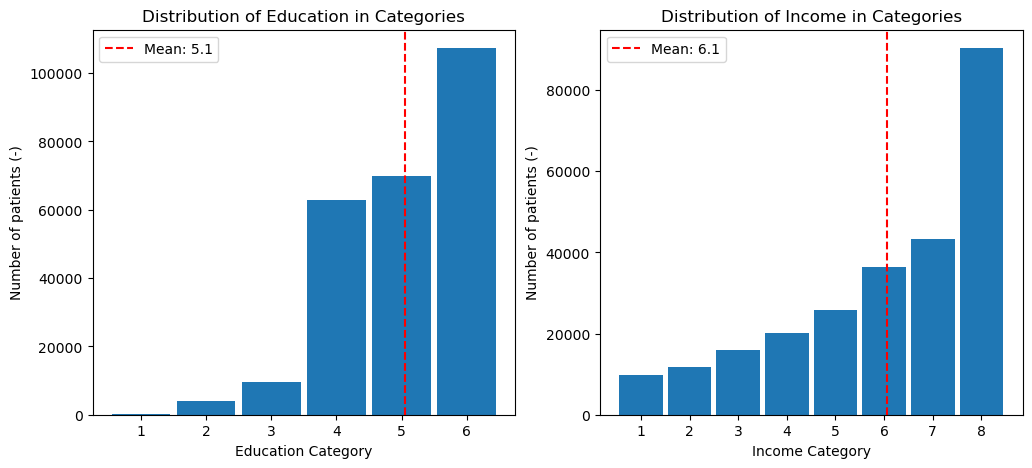

In [ ]:
# 10. Plotting socioeconomic factors (education and income)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting distribution of education
# Education level (EDUCA see codebook) scale 1-6
# 1 = Never attended school or only kindergarten
# 2 = Grades 1 through 8 (Elementary)
# 3 = Grades 9 through 11 (Some high school)
# 4 = Grade 12 or GED (High school graduate)
# 5 = College 1 year to 3 years (Some college or technical school)
# 6 = College 4 years or more (College graduate)
bin_width_education = 1
bins_education = np.arange(1 - 0.5, 6 + 1.5, bin_width_education)

axs[0].hist(diabetes_data['Education'], bins=bins_education, rwidth=0.9)
axs[0].set_xlabel("Education Category")
axs[0].set_ylabel("Number of patients (-)")
mean_education = diabetes_data['Education'].mean()
axs[0].axvline(mean_education, color='r', linestyle='--', label=f'Mean: {mean_education:.1f}')
axs[0].set_title("Distribution of Education in Categories")
axs[0].legend()
axs[0].set_xticks(np.arange(1, 7, 1));

# Plotting distribution of income
# Income scale (INCOME2 see codebook) scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more
bin_width_income = 1
bins_income = np.arange(1 - 0.5, 8 + 1.5, bin_width_income)

axs[1].hist(diabetes_data['Income'], bins=bins_income, rwidth=0.9)
axs[1].set_xlabel("Income Category")
axs[1].set_ylabel("Number of patients (-)")
mean_income = diabetes_data['Income'].mean()
axs[1].axvline(mean_income, color='r', linestyle='--', label=f'Mean: {mean_income:.1f}')
axs[1].set_title("Distribution of Income in Categories")
axs[1].legend()
axs[1].set_xticks(np.arange(1, 9, 1));

In [ ]:
# Compute absolute correlation matrix of features
corr_matrix_features = diabetes_features.corr().abs()

# Select upper triangle of correlation matrix (to avoid duplicate pairs and self-correlation)
upper_corr_matrix_features = corr_matrix_features.where(np.triu(np.ones(corr_matrix_features.shape), k=1).astype(bool))

# Find the max correlation value in the matrix
max_corr_value = np.nanmax(upper_corr_matrix_features.values)

# Find the location (row and column) of that max correlation
max_pos = np.where(upper_corr_matrix_features.values == max_corr_value)
row_idx, col_idx = max_pos[0][0], max_pos[1][0]

# Get feature names
feature_1 = corr_matrix_features.index[row_idx]
feature_2 = corr_matrix_features.columns[col_idx]

print(f"Max correlation is {max_corr_value:.2f} between '{feature_1}' and '{feature_2}'")

Max correlation is 0.52 between 'GenHlth' and 'PhysHlth'


After checking for the correlation between features, we can see that the maximal correlation is betwen the feature 'GenHlth' (general health) and 'PhysHlth' (physical health) which seems to be logical because general health of course is related to physical health. Nevertheless, a correlation of 0.52 is moderate, so keeping both features seems ok.

In [ ]:
# Feature selection via univariate feature selection method


# Feature selection via sklearn.feature_selection.mutual_info_classif which estimates mutual information for a discrete target variable.
feature_selection = mutual_info_classif(diabetes_features, diabetes_target, discrete_features='auto')

# Create a dataframe for easy viewing
feature_scores = pd.DataFrame({
    'Feature': diabetes_features.columns,
    'Information_Gain': feature_selection
}).sort_values(by='Information_Gain', ascending=False)

print(feature_scores)

                 Feature  Information_Gain
13               GenHlth          0.056011
0                 HighBP          0.055437
11         AnyHealthcare          0.050041
7           PhysActivity          0.049528
2              CholCheck          0.046806
9                Veggies          0.041660
1               HighChol          0.040299
8                 Fruits          0.038508
3                    BMI          0.032521
4                 Smoker          0.025446
17                   Sex          0.024624
18                   Age          0.024403
19             Education          0.023675
16              DiffWalk          0.023516
20                Income          0.022785
15              PhysHlth          0.015426
6   HeartDiseaseorAttack          0.013452
5                 Stroke          0.004920
14              MentHlth          0.003446
12           NoDocbcCost          0.002724
10     HvyAlcoholConsump          0.002334


We could decide on only taking a few out of all those features and maybe get rid of the ones that are not relevant. Based on the ranking, the last 4 features (Stroke, MentHlth, HvyAlcoholConsump, and NoDocbcCost) seem to have really small information gain towards the classfication of the target variable. Therefore, we are discluding them from further model training.

In [ ]:
# It can also be done directly via SelectKBest which selects k best features (here k=17)
selector = SelectKBest(score_func=mutual_info_classif, k=17)
selector.fit(diabetes_features, diabetes_target)
selector.scores_

array([0.05602364, 0.04160973, 0.04630186, 0.03383988, 0.02584256,
       0.0048055 , 0.01240216, 0.04918469, 0.03904773, 0.04148624,
       0.00246671, 0.05122271, 0.00130565, 0.0551914 , 0.00265755,
       0.01459099, 0.0238775 , 0.02383865, 0.02555286, 0.02385884,
       0.02261695])

In [ ]:
# Cutting off irrelevant features identified via SelectKBest function
mask = selector.get_support()
diabetes_features_selected = diabetes_features.loc[:, mask]
diabetes_features_selected

,HighBP,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,AnyHealthcare,GenHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,45.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,7.0,5.0,1.0


After checking for features, their distributions, correlations and information gain towards the target I am having a look at the target distribution as well.

Diabetes_012
0.0    84.241170
2.0    13.933302
1.0     1.825528
Name: proportion, dtype: float64


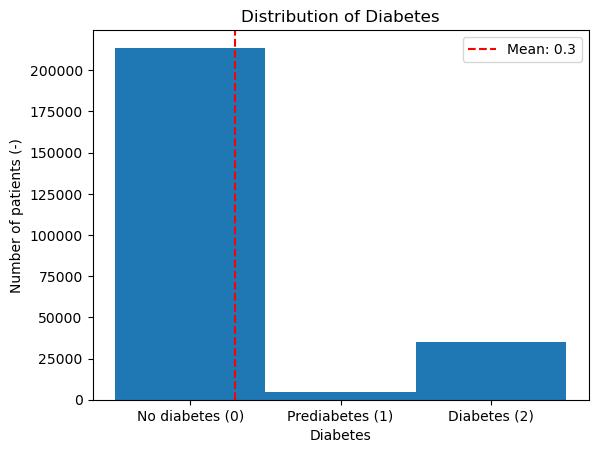

In [ ]:
# Finding out about target distribution
class_counts = diabetes_data['Diabetes_012'].value_counts().sort_index()

# Plotting histogram of class counts
bin_width_target = 1
bins_target = np.arange(0 - 0.5, 2 + 1.5, bin_width_target)

# Plotting histogram
plt.hist(diabetes_data['Diabetes_012'], bins=bins_target);
plt.xticks([0, 1, 2], ['No diabetes (0)', 'Prediabetes (1)', 'Diabetes (2)'])
plt.xlabel("Diabetes")
plt.ylabel("Number of patients (-)")
mean_target = diabetes_data['Diabetes_012'].mean()
plt.axvline(mean_target, color='r', linestyle='--', label=f'Mean: {mean_target:.1f}')
plt.title("Distribution of Diabetes")
plt.legend();

# Calculate occurrences of different classes in %
values = diabetes_target.value_counts(normalize=True)*100
print(values)


We can see that the dataset is highly unbalanced. There are way more people without diabetes, than people with prediabetes or diabetes. Therefore, any model would be biased towards the decision "No diabetes".

That is why it makes sense to solve that imbalance. This can be done by using for example an oversampling technique such as "SMOTE".

In [ ]:
# Splitting the data with prior feature selection
# I only split into training and testing data, because validation is automatically done when tuning hyperparameters for example with GridSearchCV, RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(diabetes_features_selected, diabetes_target, test_size=0.3, random_state=42, stratify = diabetes_target)

# Applying oversampling technique SMOTE
smote = SMOTE(random_state=42)
X_train_oversampling, y_train_oversampling = smote.fit_resample(X_train, y_train)

# Checking effect of SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_oversampling).value_counts())

Before SMOTE: Diabetes_012
0.0    149592
2.0     24742
1.0      3242
Name: count, dtype: int64
After SMOTE: Diabetes_012
0.0    149592
2.0    149592
1.0    149592
Name: count, dtype: int64


One can observe, that SMOTE solves the imbalance of the target. Now all classes (no diabetes: 0, prediabetes: 1, diabetes: 2) appear equally.

It is important to not apply SMOTE on the testing data, because testing should only be done on original samples.

SMOTE and scaling data can be done together in a pipeline.

In [ ]:
# Defining feature lists, dividing features into numerical, ordinal, binary features
numerical_features = ['BMI', 'MentHlth', 'PhysHlth']

ordinal_features = ['GenHlth', 'Education', 'Income', 'Age']

binary_features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'DiffWalk', 'Sex'
]


# Filter the lists to only include columns present in X_train
numerical_features_17 = [f for f in ['BMI', 'MentHlth', 'PhysHlth'] if f in diabetes_features_selected.columns]
ordinal_features_17   = [f for f in ['GenHlth', 'Education', 'Income', 'Age'] if f in diabetes_features_selected.columns]
binary_features_17    = [f for f in [
    'HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack',
    'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare',
    'NoDocbcCost','DiffWalk','Sex'
] if f in diabetes_features_selected.columns]

# Defining preprocessor for KNN and MLP Neural Network
# Only scaling numerical and ordinal eatures, leaving binary features untouched
preprocessor = ColumnTransformer(transformers=[
    ('scale_numerical', StandardScaler(), numerical_features_17),
    ('scale_ordinal', MinMaxScaler(), ordinal_features_17),
    ('passthrough_binary', 'passthrough', binary_features_17)
])


In [ ]:
# First model: KNN classifier

# Building pipeline for KNN classifier consisting of feature scaling, oversampling using SMOTE technique and KNN classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Building param grid used for hyperparameter tuning
param_grid = {
    'knn__n_neighbors': [3, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# Running grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    error_score='raise',
    n_jobs=-1,
    verbose=1
)

# Fitting grid search
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scale_numerical',
                                                                         StandardScaler(),
                                                                         ['BMI',
                                                                          'PhysHlth']),
                                                                        ('scale_ordinal',
                                                                         MinMaxScaler(),
                                                                         ['GenHlth',
                                                                          'Education',
                                                                          'Income',
                                                                          'Age']),
                                                                        ('passthrough_binary',
                                                                         'passthrough',
                                                                         ['HighBP',
                                                                          'HighChol',
                                                                          'CholCheck',
                                                                          'Smoker',
                                                                          'HeartDiseaseorAttack',
                                                                          'PhysActivity',
                                                                          'Fruits',
                                                                          'Veggies',
                                                                          'AnyHealthcare',
                                                                          'DiffWalk',
                                                                          'Sex'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 7, 9, 11], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1_macro', verbose=1)

In [ ]:
# Printing best estimator, best hyperparameters and best F1-macro score achieved for KNN model
# After running grid_search.fit(...)
results_df = pd.DataFrame(grid_search.cv_results_)

# Show selected columns: mean test score + params
print(results_df[['mean_test_score', 'std_test_score', 'params']])

print("Best estimator:\n", grid_search.best_estimator_)
print("Best hyperparameters:\n", grid_search.best_params_)
print("Best f1-macro score (training):", grid_search.best_score_)


    mean_test_score  std_test_score  \
0          0.408990        0.000988   
1          0.410849        0.001611   
2          0.398595        0.000833   
3          0.401534        0.001337   
4          0.407455        0.000715   
5          0.412542        0.001459   
6          0.389458        0.000787   
7          0.396771        0.000944   
8          0.406731        0.000660   
9          0.411994        0.001079   
10         0.387529        0.000681   
11         0.395917        0.000521   
12         0.405283        0.000966   
13         0.411698        0.001525   
14         0.386128        0.000975   
15         0.395176        0.001259   

                                               params  
0   {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__wei...  
1   {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__wei...  
2   {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__wei...  
3   {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__wei...  
4   {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__wei...  



=== KNN (Test) ===
Accuracy: 0.71
Macro Precision: 0.4114
Macro Recall:    0.4515
Macro F1:        0.4148

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9086    0.7580    0.8265     64111
         1.0     0.0263    0.0857    0.0403      1389
         2.0     0.2993    0.5109    0.3775     10604

    accuracy                         0.7113     76104
   macro avg     0.4114    0.4515    0.4148     76104
weighted avg     0.8076    0.7113    0.7496     76104



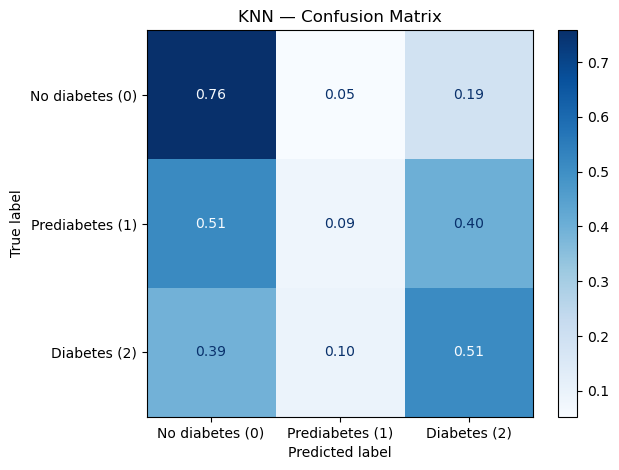

In [ ]:
# Evaluating best KNN model on test set and printing confusion matrix
evaluate_on_test("KNN", grid_search.best_estimator_, X_test, y_test)

Conducting Logistic regression

In [ ]:
#Logistic Regression with 17 features

#re-define the preprocessor such that it pass through ordinal for LR and DT
preprocessor = ColumnTransformer(transformers=[
    ('scale_numerical', StandardScaler(), numerical_features_17),
    ('passthrough_ordinal', 'passthrough', ordinal_features_17),
    ('passthrough_binary', 'passthrough', binary_features_17)
])


# Build pipeline: SMOTE -> Scale -> Logistic Regression
pipe_lr_17 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=2000
    ))
])





In [ ]:
# Building param grid used for hyperparameter tuning
param_grid = {
    'clf__C': [0.01, 0.03, 0.1, 0.3],
    'clf__class_weight': [None, 'balanced']
}

#conduct grid search to find the optimal hyperparameters
grid_lr_17 = GridSearchCV(
    estimator=pipe_lr_17,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Fitting grid search

grid_lr_17.fit(X_train, y_train)
print("Best params:", grid_lr_17.best_params_)
print("Best CV macro-F1:", grid_lr_17.best_score_)

best_lr_17 = grid_lr_17.best_estimator_



Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: F

Best params: {'clf__C': 0.01, 'clf__class_weight': None}
Best CV macro-F1: 0.42329988833584986



=== LR + MI(k=17) in-pipeline (Test) ===
Accuracy: 0.64
Macro Precision: 0.4439
Macro Recall:    0.5112
Macro F1:        0.4228

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9497    0.6576    0.7771     64111
         1.0     0.0288    0.2973    0.0525      1389
         2.0     0.3533    0.5787    0.4387     10604

    accuracy                         0.6401     76104
   macro avg     0.4439    0.5112    0.4228     76104
weighted avg     0.8498    0.6401    0.7168     76104



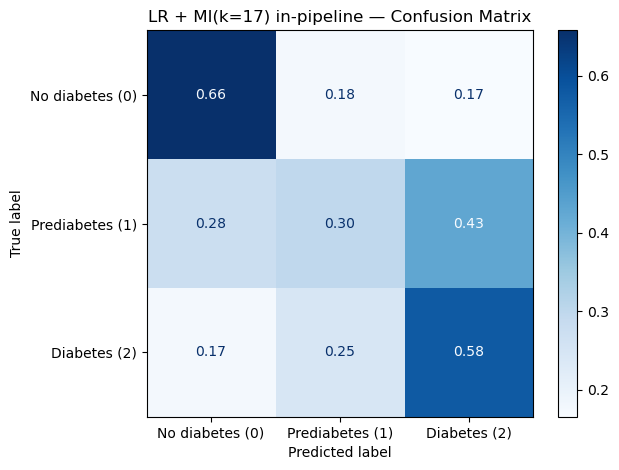

In [ ]:
#evaluate LR
evaluate_on_test("LR + MI(k=17) in-pipeline", best_lr_17, X_test, y_test)

In [ ]:
# Feature Importance Analysis - Logistic Regression

# Extract the trained LR step (after pipeline)
lr_step = best_lr_17.named_steps["clf"]

# Get feature names in original order
preprocessor = best_lr_17.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]

# Coefficients shape
coef_matrix = lr_step.coef_
coef_df = pd.DataFrame(coef_matrix, columns=feature_names, index=["Class 0 (No diabetes)", "Class 1 (Prediabetes)", "Class 2 (Diabetes)"])

print("Logistic Regression Coefficients (per class):")
display(coef_df)

# Global Importance: average absolute coefficient across classes
coef_importance = np.mean(np.abs(coef_matrix), axis=0)

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": coef_importance
}).sort_values(by="Importance", ascending=False)

print("Top 10 Most Important Features (average across classes):")
display(importance_df.head(10))


Logistic Regression Coefficients (per class):


,BMI,PhysHlth,GenHlth,Education,Income,Age,HighBP,HighChol,CholCheck,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,AnyHealthcare,DiffWalk,Sex
Class 0 (No diabetes),-0.340372,0.056419,-0.379270,0.030239,0.061815,-0.100435,-0.417987,-0.476948,-0.912496,0.017016,0.064742,-0.047759,0.004435,-0.065520,-0.179118,0.085338,-0.119344
Class 1 (Prediabetes),0.090716,-0.011708,0.073026,-0.032906,-0.039422,0.033430,-0.029469,0.247946,0.084192,0.023159,-0.233334,0.072121,0.017061,0.037176,-0.074270,-0.111318,-0.058168
Class 2 (Diabetes),0.249656,-0.044711,0.306244,0.002667,-0.022393,0.067005,0.447456,0.229002,0.828305,-0.040175,0.168592,-0.024363,-0.021496,0.028345,0.253388,0.025980,0.177511


Top 10 Most Important Features (average across classes):


,Feature,Importance
8,CholCheck,0.608331
7,HighChol,0.317965
6,HighBP,0.298304
2,GenHlth,0.252847
0,BMI,0.226914
14,AnyHealthcare,0.168925
10,HeartDiseaseorAttack,0.155556
16,Sex,0.118341
15,DiffWalk,0.074212
5,Age,0.066956


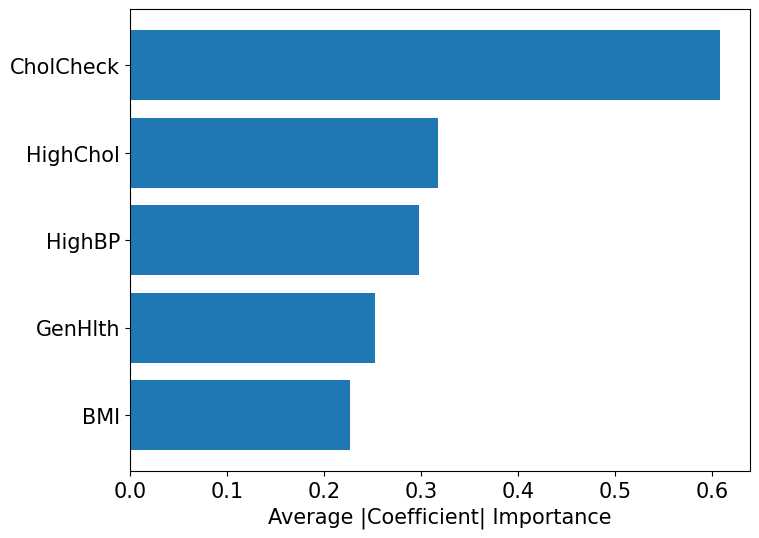

In [ ]:

top_features = importance_df.head(5)

#Plotting bar graph for top 5 most important features for Logistic Regression
plt.figure(figsize=(8,6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Average |Coefficient| Importance", size = 15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


Decision Tree

In [ ]:
#Perform grid search on dt with prior feature selection

# re-define preprocessor for DT, with only numerical features being scaled
preprocessor = ColumnTransformer(transformers=[
    ('scale_numerical', StandardScaler(), numerical_features_17),
    ('passthrough_ordinal', 'passthrough', ordinal_features_17),
    ('passthrough_binary', 'passthrough', binary_features_17)
])

# creating pipeline for DT, scale -> SMOTE -> DT
pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("dt", DecisionTreeClassifier(random_state=42))
  ])

# Building param grid used for hyperparameter tuning
param_grid_dt = {
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": [11, 12, 13, 14],
    "dt__min_samples_split": [2, 5, 10],
    "dt__min_samples_leaf": [1, 3, 5, 10],
    "dt__class_weight": [None, "balanced"]
}

# run grid search
grid_search_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=3,
    scoring="f1_macro",
    error_score="raise",
    n_jobs=-1,
    verbose=1
)

# Fitting grid search
grid_search_dt.fit(X_train, y_train)

print("Best parameters DT_f1:", grid_search_dt.best_params_)
print("Best CV macro-F1 DT_f1:", grid_search_dt.best_score_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best parameters DT_f1: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 11, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5}
Best CV macro-F1 DT_f1: 0.4420269633439437



=== Decision Tree (Best for Macro-F1) (Test) ===
Accuracy: 0.76
Macro Precision: 0.4317
Macro Recall:    0.4724
Macro F1:        0.4430

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9125    0.8146    0.8608     64111
         1.0     0.0279    0.0432    0.0339      1389
         2.0     0.3548    0.5595    0.4342     10604

    accuracy                         0.7650     76104
   macro avg     0.4317    0.4724    0.4430     76104
weighted avg     0.8186    0.7650    0.7862     76104



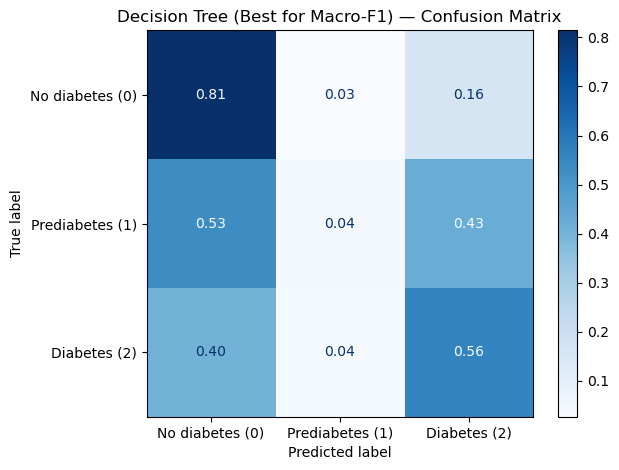

In [ ]:
# evaluate DT
best_dt_f1 = grid_search_dt.best_estimator_


evaluate_on_test("Decision Tree (Best for Macro-F1)", best_dt_f1, X_test, y_test)




    Feature  Importance
6    HighBP    0.289644
2   GenHlth    0.209843
7  HighChol    0.114251
0       BMI    0.093981
5       Age    0.088202


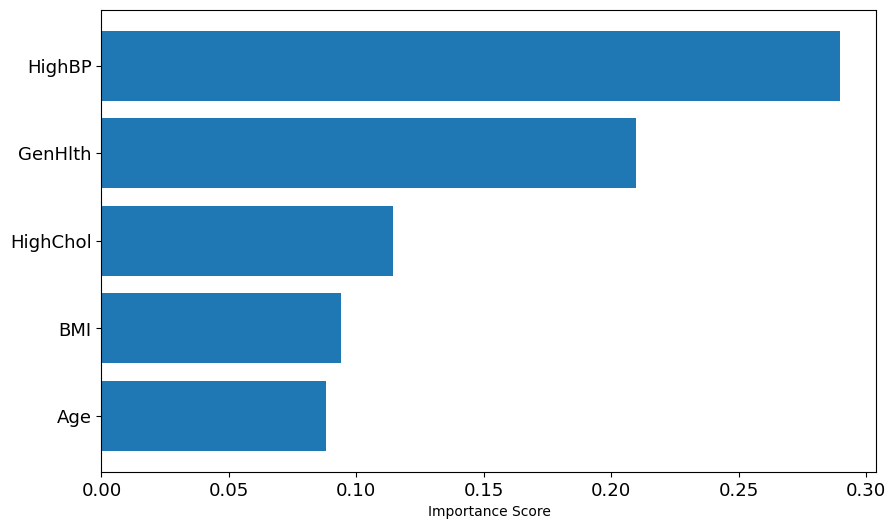

In [ ]:
# Feature Importance Analysis - Decision Tree

dt = best_dt_f1.named_steps['dt']

preprocessor = best_dt_f1.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]


# Get feature importance from DT
importances = dt.feature_importances_

feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show the top features
print(feat_importances.head(5))

# Bar Plot to visualize the top 5 features
plt.figure(figsize=(10,6))
plt.barh(feat_importances["Feature"][:5], feat_importances["Importance"][:5])
plt.gca().invert_yaxis()

plt.xlabel("Importance Score")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

#Multilayer perceptron neural network

Since neural networks are very computationally expensive, we cannot use SMOTE to handle imbalanced datasets, as it would significantly increase the dataset size and make hyperparameter tuning very time-consuming. Instead, we use an undersampling technique, which also addresses class imbalance but reduces the dataset size, making training more computationally feasible.

In [ ]:
# Check how many samples per class there are
print(y_train.value_counts())

Diabetes_012
0.0    149592
2.0     24742
1.0      3242
Name: count, dtype: int64


<Axes: ylabel='count'>

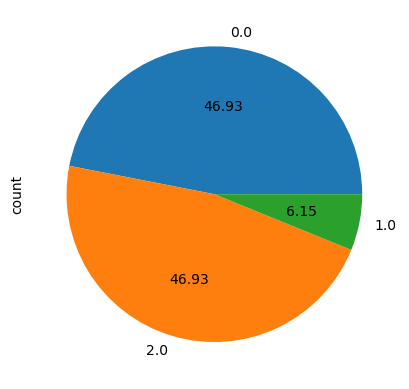

In [ ]:
# Perform undersampling (instead of SMOTE)
rus = RandomUnderSampler(sampling_strategy={0: 24742, 2: 24742, 1: 3242}, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# See the proportion after undersampling
y_train_under.value_counts().plot.pie(autopct='%.2f')

We can now perform hyperparameter tuning using the undersampled training data.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyperparameters:
 {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (100,)}
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     64111
         1.0       0.00      0.00      0.00      1389
         2.0       0.31      0.79      0.44     10604

    accuracy                           0.72     76104
   macro avg       0.42      0.50      0.42     76104
weighted avg       0.84      0.72      0.75     76104



/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/smokiemac/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


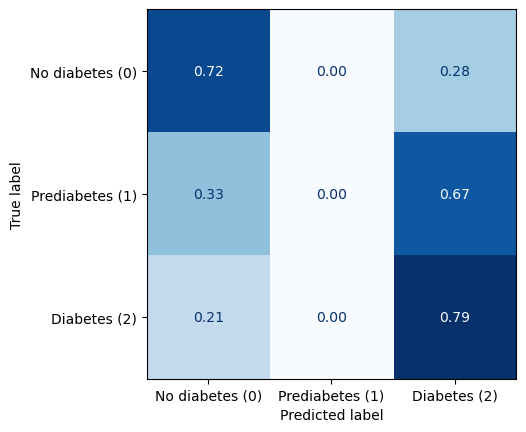

In [ ]:
# Use the same processor as for the other models
preprocessor_mlp = ColumnTransformer(transformers=[
    ('scale_numerical', StandardScaler(), numerical_features_17),
    ('scale_ordinal', MinMaxScaler(), ordinal_features_17),
    ('passthrough_binary', 'passthrough', binary_features_17)
])

# Set up a pipeline
pipeline_mlp = Pipeline([
    ('preprocessor', preprocessor_mlp),
    ('mlp', MLPClassifier(max_iter=5000, random_state=42))
])

# Set up params to tune for MLP
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50,50)],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Find the best params
grid_search_mlp = GridSearchCV(
    estimator=pipeline_mlp,
    param_grid=param_grid_mlp,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp.fit(X_train_under, y_train_under)

# Best params
print("Best hyperparameters:\n", grid_search_mlp.best_params_)

# Evaluate the model with best params
y_pred = grid_search_mlp.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ["No diabetes (0)", "Prediabetes (1)", "Diabetes (2)"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='.2f', colorbar=False)

plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.title("")

plt.show()

We can see that, even though we applied undersampling, we only matched the majority class with the second-largest class, and the smallest class still has fewer samples. This might be the reason why this model completely disregards it (prediabetes), resulting in an accuracy of 0 for it.

As an attempt to address this, we can apply SMOTE only to the minority class to match it with the other two classes and see if that improves the results.

Diabetes_012
0.0    24742
1.0    24742
2.0    24742
Name: count, dtype: int64


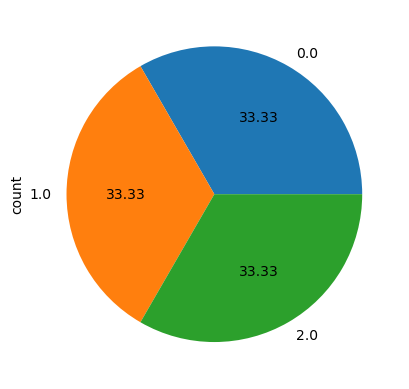

In [ ]:
# Apply SMOTE to the minority class
smote = SMOTE(sampling_strategy={1:24742}, random_state=42)
X_train_under_smote, y_train_under_smote = smote.fit_resample(X_train_under, y_train_under)

# See the proportion after SMOTE
y_train_under_smote.value_counts().plot.pie(autopct='%.2f')
print(y_train_under_smote.value_counts())

              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81     64111
         1.0       0.03      0.01      0.02      1389
         2.0       0.30      0.80      0.44     10604

    accuracy                           0.70     76104
   macro avg       0.43      0.50      0.42     76104
weighted avg       0.84      0.70      0.74     76104



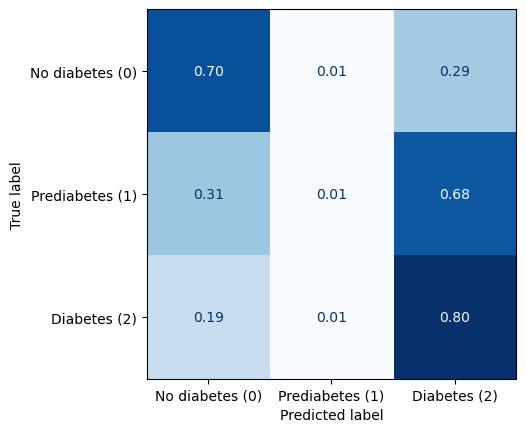

In [ ]:

# Set up a new pipeline (with best hyperparams that we found)
pipeline_mlp2 = Pipeline([
    ('preprocessor', preprocessor_mlp),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), alpha=0.1, max_iter=5000, random_state=42))
])

# Train the MLP on the resampled data
pipeline_mlp2.fit(X_train_under_smote, y_train_under_smote)

# Evaluate on test set
y_pred = pipeline_mlp2.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ["No diabetes (0)", "Prediabetes (1)", "Diabetes (2)"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='.2f', colorbar=False)

plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.title("")

plt.show()

Since this did not improve the accuracy for the prediabetes class, the issue is likely not due to class imbalance. Therefore, there is nothing further to be done in this regard, and our best result remains an F1-macro score of 0.42.

## Create a piechart showing the progression of undersampling and SMOTE.

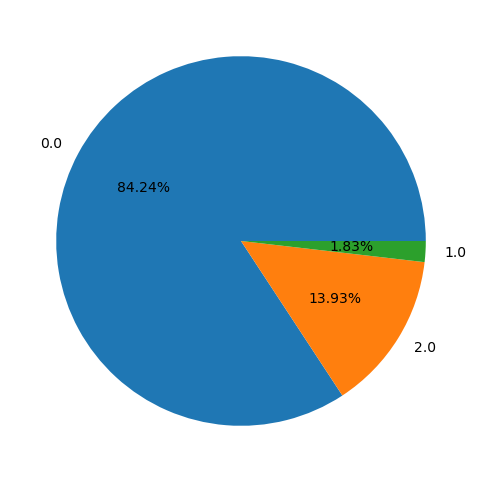

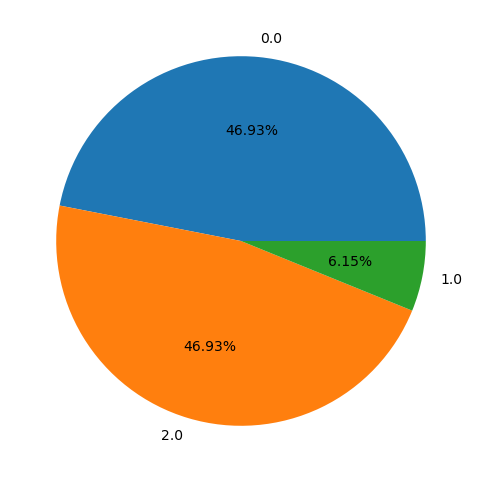

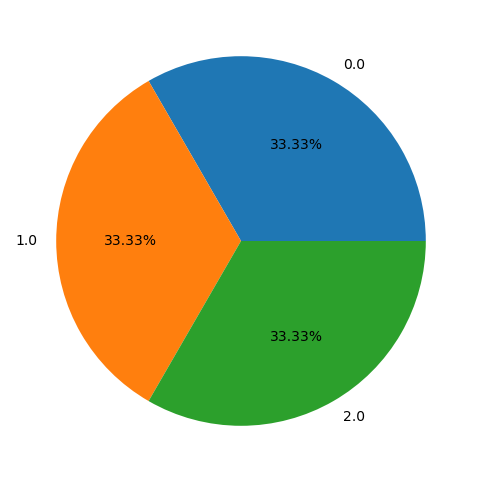

In [ ]:
# Pie chart for Original data
plt.figure(figsize=(6,6))
y_train.value_counts().plot.pie(autopct='%.2f%%', ylabel='')
plt.show()

# Pie chart for Data after undersampling
plt.figure(figsize=(6,6))
y_train_under.value_counts().plot.pie(autopct='%.2f%%', ylabel='')
plt.show()

# Pie chart for After undersampling and SMOTE
plt.figure(figsize=(6,6))
y_train_under_smote.value_counts().plot.pie(autopct='%.2f%%', ylabel='')
plt.show()

# Predictive power of the best features from LR and DT

Predictive power of the top 2 DT features

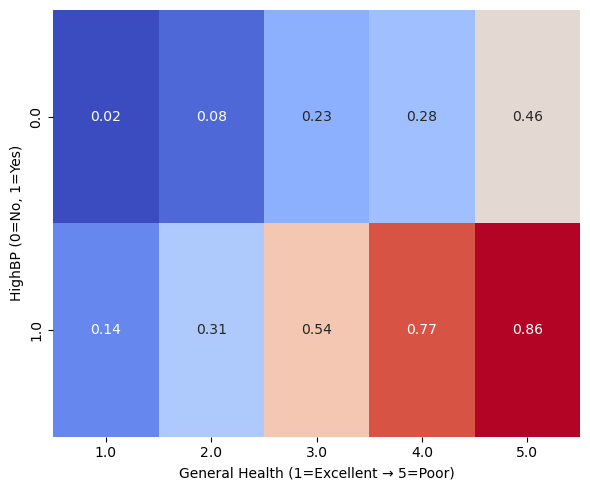

In [ ]:
# Exploring relationship between HighBP (binary)
# and GenHlth (ordinal: 1=Excellent → 5=Poor)

# Optional subset if dataset is very large
subset_size = 5000
if len(diabetes_data) > subset_size:
    _, diabetes_subset = train_test_split(
        diabetes_data,
        stratify=diabetes_data['Diabetes_012'],
        test_size=subset_size,
        random_state=42
    )
else:
    diabetes_subset = diabetes_data.copy()

expected_val = (
    diabetes_subset
    .groupby(["HighBP", "GenHlth"])["Diabetes_012"]
    .mean()
    .unstack()
)


plt.figure(figsize=(6, 5))
sns.heatmap(
    expected_val,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=False
)
plt.title("")
plt.xlabel("General Health (1=Excellent → 5=Poor)")
plt.ylabel("HighBP (0=No, 1=Yes)")
plt.tight_layout()
plt.show()


Predictive power of the top 2 LR features

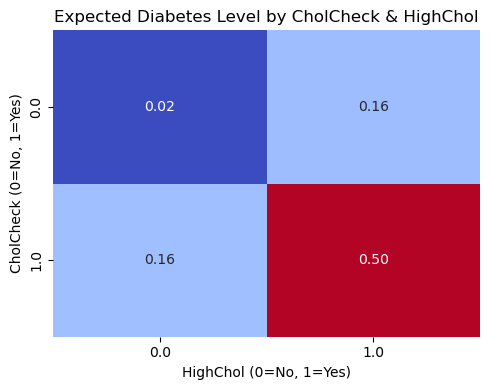

In [ ]:
# Exploring relationship between CholCheck (binary) and HighChol (binary)

# Subset
subset_size = 5000
if len(diabetes_data) > subset_size:
    _, diabetes_subset = train_test_split(
        diabetes_data,
        stratify=diabetes_data['Diabetes_012'],
        test_size=subset_size,
        random_state=42
    )
else:
    diabetes_subset = diabetes_data.copy()

# Compute expected diabetes level for each CholCheck & HighChol combination
expected_val_chol = (
    diabetes_subset
    .groupby(["CholCheck", "HighChol"])["Diabetes_012"]
    .mean()
    .unstack()
)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    expected_val_chol,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar=False
)
plt.title("Expected Diabetes Level by CholCheck & HighChol")
plt.xlabel("HighChol (0=No, 1=Yes)")
plt.ylabel("CholCheck (0=No, 1=Yes)")
plt.tight_layout()
plt.show()


Barplots for model comparison

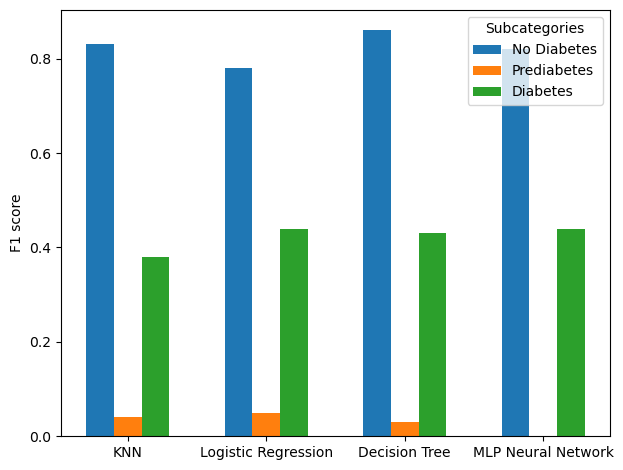

In [ ]:
# Main categories (x-axis groups)
categories = ["KNN", "Logistic Regression", "Decision Tree", "MLP Neural Network"]

# Subcategories (bars within each group)
subcategories = ["No Diabetes", "Prediabetes", "Diabetes"]

# Data: One value for each (category, subcategory) pair
# Shape: (number of subcategories, number of categories)
values = [
    [0.83, 0.04, 0.38],  # Subcategory X values
    [0.78, 0.05, 0.44],  # Subcategory Y values
    [0.86, 0.03, 0.43],
    [0.82, 0.00, 0.44],

]

values = list(map(list, zip(*values)))

# Set width of each bar
bar_width = 0.2

# X positions for each group
x = np.arange(len(categories))  # [0, 1, 2]

# Plot each subcategory, offset by bar width
for i in range(len(subcategories)):
    plt.bar(x + i * bar_width, values[i], width=bar_width, label=subcategories[i])

# Labeling
plt.ylabel("F1 score", fontsize=10)
plt.xticks(x + bar_width, categories, fontsize=10)  # Center the x-ticks under the groups
plt.legend(title="Subcategories")
plt.tight_layout()
plt.savefig("f1_scores_classes.png")
plt.show()

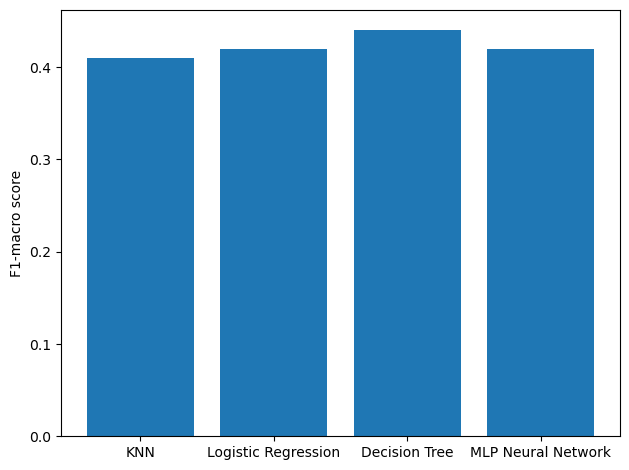

In [ ]:
# Categories (models)
categories = ["KNN", "Logistic Regression", "Decision Tree", "MLP Neural Network"]

# F1 scores for each model
values = [0.41, 0.42, 0.44, 0.42]

# X positions for each bar
x = np.arange(len(categories))

# Plot bars
plt.bar(x, values)

# Labeling
plt.ylabel("F1-macro score", fontsize=10)
plt.xticks(x, categories, fontsize=10)

plt.tight_layout()
plt.savefig("f1_scores_models.png")
plt.show()